In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import os
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import keras
from sklearn.model_selection import train_test_split
# from keras.preprocessing.image import ImageDataGenerator


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import pickle

In [3]:
train_folder = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
1,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
2,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
3,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
4,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
...,...,...
86995,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86996,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86997,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86998,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...


In [4]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.10, random_state=42,stratify=x_train[['label']])

In [25]:
print(x_test[x_col].apply(type))


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [31]:
print(x_train.dtypes)


label    object
path     object
dtype: object


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


img_width, img_height = 64,64
batch_size = 256
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())

train_datagen = ImageDataGenerator(rescale=1/255.0)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,  # Potential issue: Are x_train, x_test, x_holdout data frames?
    x_col=x_col,
    y_col=y_col,
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale=1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test,  # Potential issue: Are x_train, x_test, x_holdout data frames?
    x_col=x_col,
    y_col=y_col,
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)

holdout_datagen = ImageDataGenerator(rescale=1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout,  # Potential issue: Are x_train, x_test, x_holdout data frames?
    x_col=x_col,
    y_col=y_col,
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)


Found 70470 validated image filenames belonging to 29 classes.
Found 7830 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


MOBILENET

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from keras.layers import DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D

model = Sequential()

# Entry Flow
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Middle Flow
for _ in range(4):
    model.add(DepthwiseConv2D((3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())

# Exit Flow
model.add(DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())

# Output layer
model.add(Dense(29, activation='softmax'))

model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_7              │ (None, 64, 64, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_8              │ (None, 32, 32, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_9              │ (None, 16, 16, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_10             │ (None, 16, 16, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 128)    │        16,51

 Total params: 132,125 (516.11 KB)

 Trainable params: 128,669 (502.61 KB)

 Non-trainable params: 3,456 (13.50 KB)

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [10]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

batch_size=32

history = model.fit(train_generator,
                    epochs=5,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks = [early_stop])

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-13 19:51:19.583459: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 2.52205, expected 2.04843
2024-04-13 19:51:19.583530: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1280: 3.68618, expected 3.21256
2024-04-13 19:51:19.583570: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8192: 2.56124, expected 1.61154
2024-04-13 19:51:19.583579: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8193: 4.15056, expected 3.20085
2024-04-13 19:51:19.583588: E external/local_xla/xla/service/gpu/buffer_compar

  2/276 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - accuracy: 0.0273 - loss: 3.3888   

I0000 00:00:1713037892.206458      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/276 ━━━━━━━━━━━━━━━━━━━━ 1:30 1s/step - accuracy: 0.5078 - loss: 1.8146

2024-04-13 19:56:52.530873: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.43261, expected 2.8373
2024-04-13 19:56:52.530939: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.93246, expected 4.33714
2024-04-13 19:56:52.530951: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 43: 4.88195, expected 4.28664
2024-04-13 19:56:52.530961: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62: 4.64353, expected 4.04821
2024-04-13 19:56:52.530970: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 2.9248, expected 2.32948
2024-04-13 19:56:52.530979: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64: 4.29544, expected 3.70013
2024-04-13 19:56:52.530988: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 127: 3.8003, expected 3.20498
2024-04-13 19:56:52.530998: E external/local_xla/xla

276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5706 - loss: 1.5935

2024-04-13 19:59:00.878113: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8255: 2.21789, expected 1.79619
2024-04-13 19:59:00.878178: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9344: 3.15744, expected 2.73574
2024-04-13 19:59:00.878198: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11839: 3.15087, expected 2.72917
2024-04-13 19:59:00.878207: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12224: 3.15142, expected 2.72972
2024-04-13 19:59:00.878216: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12256: 3.13556, expected 2.71386
2024-04-13 19:59:00.878223: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12261: 2.84217, expected 2.42047
2024-04-13 19:59:00.878232: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12287: 2.3471, expected 1.9254
2024-04-13 19:59:00.878257: E e

276/276 ━━━━━━━━━━━━━━━━━━━━ 488s 2s/step - accuracy: 0.5715 - loss: 1.5904 - val_accuracy: 0.0345 - val_loss: 7.1279
Epoch 2/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 102s 361ms/step - accuracy: 0.9947 - loss: 0.0427 - val_accuracy: 0.0349 - val_loss: 10.8170
Epoch 3/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 103s 363ms/step - accuracy: 0.9998 - loss: 0.0074 - val_accuracy: 0.9877 - val_loss: 0.0416
Epoch 4/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 103s 362ms/step - accuracy: 0.9995 - loss: 0.0056 - val_accuracy: 0.9991 - val_loss: 0.0055
Epoch 5/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 104s 368ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0012


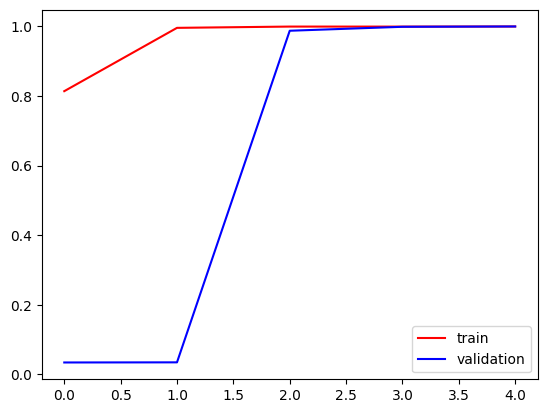

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

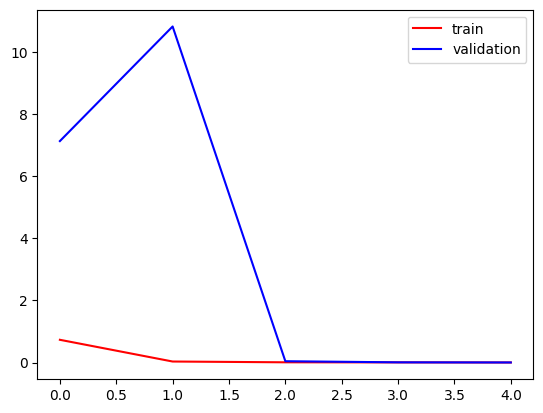

In [12]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [13]:
# Evaluate the model on the holdout set
holdout_evaluation = model.evaluate(holdout_generator)

# Print the evaluation metrics
print("Holdout Loss:", holdout_evaluation[0])
print("Holdout Accuracy:", holdout_evaluation[1])


33/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 1.0000 - loss: 0.0011

2024-04-13 20:08:45.502869: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.6517, expected 3.89452
2024-04-13 20:08:45.502950: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.4732, expected 3.71602
2024-04-13 20:08:45.502960: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.32145, expected 4.56428
2024-04-13 20:08:45.502969: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.99975, expected 4.24258
2024-04-13 20:08:45.502977: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.77102, expected 5.01385
2024-04-13 20:08:45.503003: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.45793, expected 5.70076
2024-04-13 20:08:45.503012: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.03285, expected 5.27568
2024-04-13 20:08:45.503021: E external/local_xla/xla/serv

34/34 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 1.0000 - loss: 0.0011
Holdout Loss: 0.0013682753778994083
Holdout Accuracy: 0.999885082244873


34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 516ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300
           4       1.00      1.00      1.00       300
           5       1.00      1.00      1.00       300
           6       1.00      1.00      1.00       300
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       300
           9       1.00      1.00      1.00       300
          10       1.00      1.00      1.00       300
          11       1.00      1.00      1.00       300
          12       1.00      1.00      1.00       300
          13       1.00      1.00      1.00       300
          14       1.00      1.00      1.00       300
          15       1.00      1.00      1.00       300
          16    

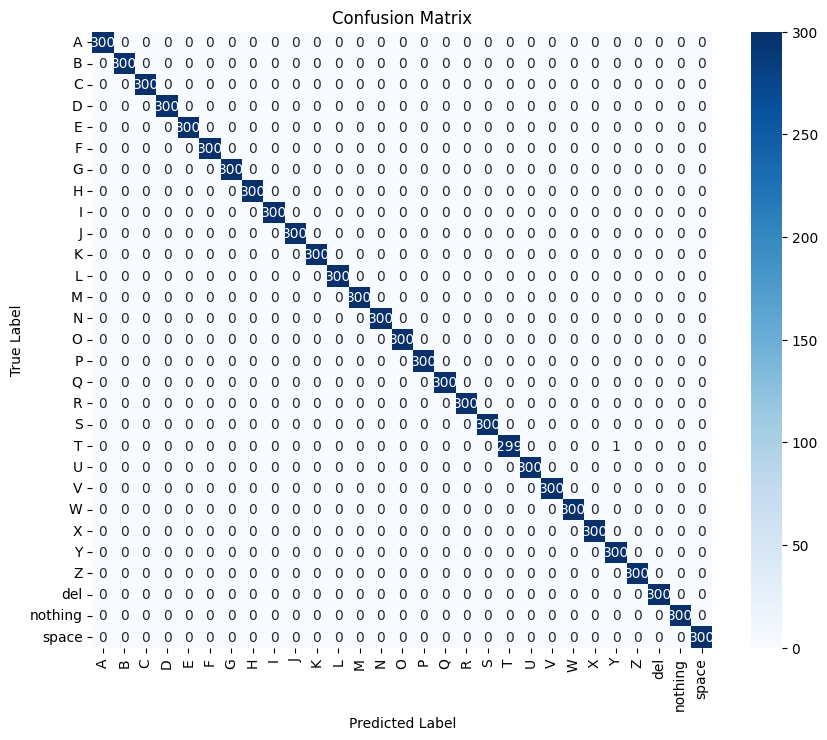

In [27]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Make Predictions
holdout_predictions = model.predict(holdout_generator)

# 2. Convert predictions to class labels
holdout_pred_labels = np.argmax(holdout_predictions, axis=1)

# 3. Get true labels
true_labels = holdout_generator.classes

# 4. Compute Metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

# Classification Report
classification_rep = classification_report(true_labels, holdout_pred_labels)
print("Classification Report:")
print(classification_rep)

# ROC-AUC Score
roc_auc = roc_auc_score(to_categorical(true_labels, num_classes=no_of_classes), holdout_predictions)
print("ROC-AUC Score:", roc_auc)

# 5. Generate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, holdout_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=holdout_generator.class_indices.keys(), yticklabels=holdout_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
#


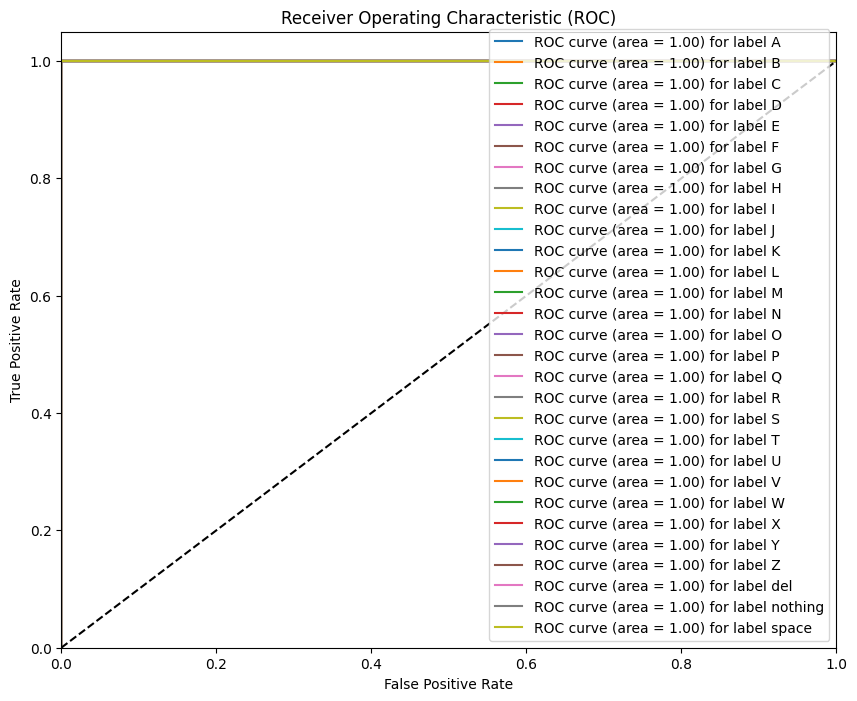

In [17]:
# 6. Plot ROC Curves
from sklearn.metrics import auc

plt.figure(figsize=(10, 8))
fpr = {}
tpr = {}
roc_auc = {}
for i in range(no_of_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(true_labels, num_classes=no_of_classes)[:, i], holdout_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

class_labels = list(holdout_generator.class_indices.keys())  # Convert dict_keys object to a list

for i in range(no_of_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], class_labels[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


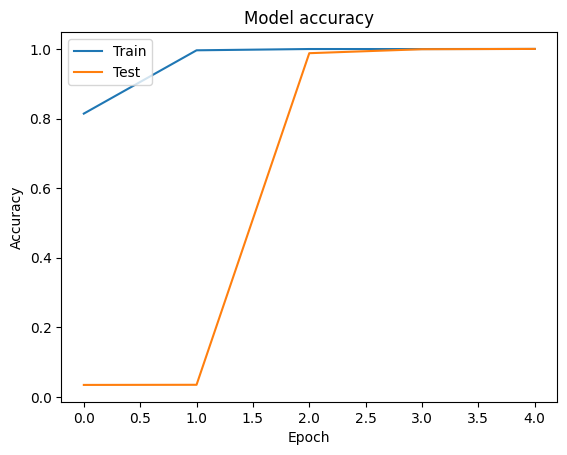

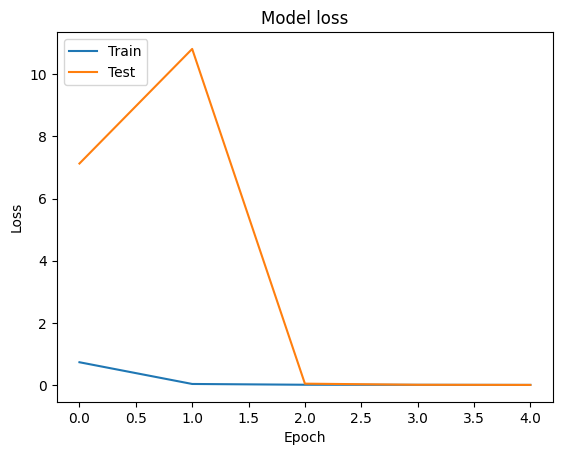

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [21]:
from keras.preprocessing import image
import numpy as np

# Load the image
img_path = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/T/T1015.jpg'  # Replace 'path_to_your_image.jpg' with the path to your image
img = image.load_img(img_path, target_size=(64, 64))  # Assuming your model expects input size of (64, 64)

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize pixel values

# Make prediction
prediction = model.predict(img_array)

# Decode the prediction
predicted_label = np.argmax(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [22]:
# Define the dictionary
class_labels = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 
    10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 
    19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z',
    26: 'del', 27: 'nothing', 28: 'space'
}
prediction = model.predict(img_array)

# Decode the prediction
predicted_label_index = np.argmax(prediction)
predicted_label = class_labels[predicted_label_index]

print("Predicted label:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted label: T


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


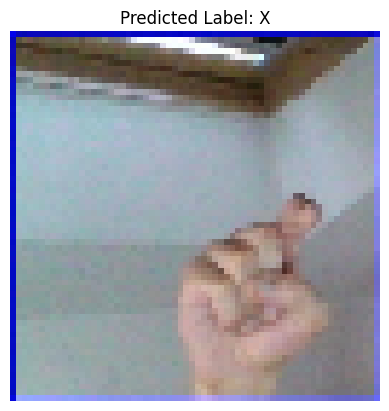

In [26]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img_path = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/X/X1004.jpg'  # Replace 'path_to_your_image.jpg' with the path to your image
img = image.load_img(img_path, target_size=(64, 64))  # Assuming your model expects input size of (64, 64)

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize pixel values

# Make prediction
prediction = model.predict(img_array)

# Decode the prediction
predicted_label_index = np.argmax(prediction)
predicted_label = class_labels[predicted_label_index]

# Display the image
plt.imshow(img)
plt.title("Predicted Label: " + predicted_label)
plt.axis('off')
plt.show()


In [ ]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

DENSENET